# Install forked version of Neurogym 

You may need to download the latest neurogym from RYZ

```bash
git clone git@github.com:ruyuanzhang/neurogym.git
cd neurogym
pip install -e .
```
Also, you need to switch to the branch 'RNNmotion'
```bash
git switch RNNmotion
```

In [ ]:
# This is the script to train the spatial suppression motion neural network
# We simplified the task input. This script should be run under neurogym/simple branch.
# In this case, we assume that RNN received the input of a set of direction-selective neurons

# The input is a group of direction selective neurons. A total of 4 (directions) x 8 (size) 
#

import numpy as np
import torch
import torch.nn as nn
import neurogym as ngym

%cd ~/Dropbox/Experiments/21RNNmotion/snnmotion

# ========= define some parameters ===================
batch_size = 16
seq_len = 
hidden_size = 256
output_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========= initilize the neurogym object ============
task = 'SpatialSuppressMotion-v0' # Note the upper case and the version tag 
#kwargs = {'win_kwargs': {'size':(200, 200)}}
kwargs = {}
# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=batch_size,
                       seq_len=seq_len, cache_len=0)
env = dataset.env


In [18]:
# ======= test ===========
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
print('input size is ', inputs.shape)
print('label size is ', labels.shape)

input size is  torch.Size([36, 16, 44])
label size is  torch.Size([36, 16, 4])


Text(0, 0.5, 'Probability')

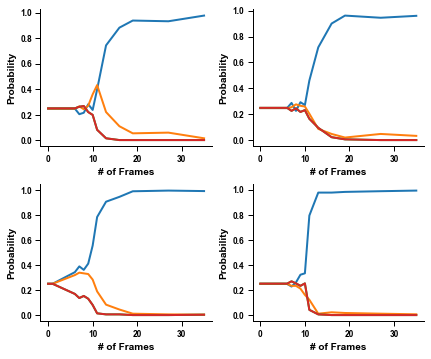

In [17]:
# We can take a look the groundtruth psychometric functions
# 2(contrast=0.05/0.99) x 2 (diameter=1/11) = 4 conditions
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
inputs, labels = dataset(contrast=0.99, diameter=11, direction=1)
plt.sca(ax[0,0]);
plt.plot(labels[:,0,:]); plt.xlabel('# of Frames'); plt.ylabel('Probability')

plt.sca(ax[0,1]);
inputs, labels = dataset(contrast=0.05, diameter=1, direction=1) # 2(contrast=0.05/0.99) x 2 (size=1/11) = 4 conditions
plt.plot(labels[:,0,:]); plt.xlabel('# of Frames'); plt.ylabel('Probability')

plt.sca(ax[1,0]);
inputs, labels = dataset(contrast=0.99, diameter=1, direction=1) # 2(contrast=0.05/0.99) x 2 (size=1/11) = 4 conditions
plt.plot(labels[:,0,:]); plt.xlabel('# of Frames'); plt.ylabel('Probability')

plt.sca(ax[1,1]);
inputs, labels = dataset(contrast=0.05, diameter=11, direction=1) # 2(contrast=0.05/0.99) x 2 (size=1/11) = 4 conditions
plt.plot(labels[:,0,:]); plt.xlabel('# of Frames'); plt.ylabel('Probability')

In [ ]:
# =============== network setting ===================
from motionnet import motionNet
net = motionNet(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 500], gamma=0.1)

In [ ]:
# this step can be repeated several times until reaching satifising loss value.
# typically you can obtain good results if loss < 0.003
lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
running_loss = 0.0
for i in range(20000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels).type(torch.float).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs,_ = net(inputs)

    loss = criterion(outputs.view(-1, output_size), labels.view(-1, output_size))
    loss.backward()
    optimizer.step()
    #scheduler.step()

    # print statistics
    running_loss += loss.item()
#    if running_loss / 200 / batch_size * 1000 < 0.0005:
#        print(running_loss / 200 / batch_size * 1000)
#        break  # Converge, we break the for loop

    if i % 20 == 19:
        print('{:d} loss: {:0.5f}'.format(i + 1, running_loss / 200 / batch_size * 1000))
        running_loss = 0.0 # the model is good if loss ~= 0.0001

print('Finished Training')

Text(0, 0.5, 'Probablity')

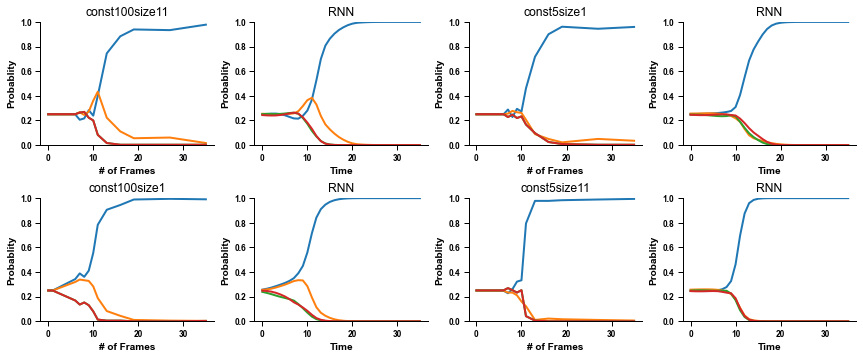

In [22]:
# ============== plot the figure ======================
fig, ax = plt.subplots(2, 4, figsize=(12, 5))

# large high contrast
inputs, labels = dataset(contrast=0.99, diameter=11, direction=1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
# inputs is a [seq_len, batch_size, H, W, C]
# preprocessing
# to (seq_len, batch_size, input_size)
Y, _ = net(inputs)
Y = Y.view(seq_len, -1, output_size)
Y = Y.detach().numpy()

plt.sca(ax[0, 0])
plt.plot(labels[:, 0, :])
plt.ylim([0, 1])
plt.title('const100size11'); plt.xlabel('# of Frames'); plt.ylabel('Probablity')
plt.sca(ax[0, 1])
plt.plot(Y[:, 0, :])
plt.ylim([0, 1])
plt.title('RNN')
plt.xlabel('Time')
plt.ylabel('Probablity')

# small low contrast
inputs, labels = dataset(contrast=0.05, diameter=1, direction=1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
Y, _ = net(inputs)
Y = Y.view(seq_len, -1, output_size)
Y = Y.detach().numpy()

plt.sca(ax[0, 2])
plt.plot(labels[:, 0, :])
plt.ylim([0, 1])
plt.title('const5size1'); plt.xlabel('# of Frames'); plt.ylabel('Probablity')
plt.sca(ax[0, 3])
plt.plot(Y[:, 0, :])
plt.ylim([0, 1])
plt.title('RNN')
plt.xlabel('Time')
plt.ylabel('Probablity')

# small high contrast
inputs, labels = dataset(contrast=0.99, diameter=1, direction=1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
Y, _ = net(inputs)
Y = Y.view(seq_len, -1, output_size)
Y = Y.detach().numpy()

plt.sca(ax[1, 0])
plt.plot(labels[:, 0, :])
plt.ylim([0, 1])
plt.title('const100size1'); plt.xlabel('# of Frames'); plt.ylabel('Probablity')
plt.sca(ax[1, 1])
plt.plot(Y[:, 0, :])
plt.ylim([0, 1])
plt.title('RNN')
plt.xlabel('Time')
plt.ylabel('Probablity')

# large small contrast
inputs, labels = dataset(contrast=0.05, diameter=11, direction=1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
Y, _ = net(inputs)
Y = Y.view(seq_len, -1, output_size)
Y = Y.detach().numpy()

plt.sca(ax[1, 2])
plt.plot(labels[:, 0, :])
plt.ylim([0, 1])
plt.title('const5size11'); plt.xlabel('# of Frames'); plt.ylabel('Probablity')
plt.sca(ax[1, 3])
plt.plot(Y[:, 0, :])
plt.ylim([0, 1])
plt.title('RNN')
plt.xlabel('Time')
plt.ylabel('Probablity')

In [21]:
torch.save(net.state_dict(),'RNNmotion_20210217.pt')